In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, WeightedRandomSampler
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import os
from PIL import Image
#pip install opencv-python (for cv2)

In [2]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images
    transforms.ToTensor(),  # Convert images to tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize
])

In [5]:
######Stratified Sampling:########

train_dataset = datasets.ImageFolder(root='/users/edatkinson/LLL/split_classes/train/', transform=transform)
val_dataset = datasets.ImageFolder(root='/users/edatkinson/LLL/split_classes/validation/', transform=transform)

# Calculate weights for each class
train_targets = torch.tensor(train_dataset.targets)
class_sample_count = torch.tensor([(train_targets == t).sum() for t in torch.unique(train_targets, sorted=True)])
print(class_sample_count)
weight = 1. / class_sample_count.float()
print(weight)
samples_weight = torch.tensor([weight[t] for t in train_targets])
# WeightedRandomSampler for training set
train_sampler = WeightedRandomSampler(weights=samples_weight, num_samples=len(samples_weight), replacement=True)

# For validation, you can repeat the process if you want stratified sampling there as well
# val_targets = torch.tensor(val_dataset.targets)
# val_class_sample_count = torch.tensor([(val_targets == t).sum() for t in torch.unique(val_targets, sorted=True)])
# val_weight = 1. / val_class_sample_count.float()
# val_samples_weight = torch.tensor([val_weight[t] for t in val_targets])

# val_sampler = WeightedRandomSampler(weights=val_samples_weight, num_samples=len(val_samples_weight), replacement=True)

# Data loaders with stratified sampling
train_loader = DataLoader(train_dataset, batch_size=32,sampler=train_sampler)
val_loader = DataLoader(val_dataset, batch_size=32)

tensor([1260, 1456,  230, 9661,  398])
tensor([0.0008, 0.0007, 0.0043, 0.0001, 0.0025])


In [6]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.pool1 = nn.MaxPool2d(2, 2)  # Adding pooling layer
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool2 = nn.MaxPool2d(2, 2)  # Adding pooling layer
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.pool3 = nn.MaxPool2d(2, 2)  # Adding pooling layer
        
        # After 3 rounds of halving the dimensions, the size calculation needs adjustment
        # For an input of 224x224, after three poolings, the size is 224 / 2 / 2 / 2 = 28
        self.fc1_size = 64 * 28 * 28  # Adjusted based on the pooling layers
        self.fc1 = nn.Linear(self.fc1_size, 500)
        self.fc2 = nn.Linear(500, 6)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))  # Apply pooling
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))  # Apply pooling
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))  # Apply pooling
        x = x.view(-1, self.fc1_size)  # Flatten the output for the fully connected layer
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [7]:
#custom cross entropy loss function

class CustomCrossEntropyLoss(torch.nn.Module):
    def __init__(self):
        super(CustomCrossEntropyLoss, self).__init__()

    def forward(self, input, target):
        log_softmax_values = torch.log_softmax(input, dim=1)
        
        # Calculate class weights
        class_weights = torch.tensor([1.0 / count for count in torch.bincount(target)], device=input.device)
        
        # Weight the losses by class weights
        weighted_losses = -target * log_softmax_values * class_weights[target]
        
        return torch.mean(torch.sum(weighted_losses, dim=1))


# Create the model, loss function, and optimizer
model = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-6)

In [8]:
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

if train_on_gpu:
    model.cuda()

n_epochs = 1
print_every = 50

for epoch in range(n_epochs):
    train_loss = 0.0
    correct = 0
    total = 0
    
    for batch_idx, (images, labels) in enumerate(train_loader):
        if train_on_gpu:
            images, labels = images.cuda(), labels.cuda()  # Move data to GPU
        
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * images.size(0)
        _, predicted = torch.max(output, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        if (batch_idx + 1) % print_every == 0:
            accuracy = 100 * correct / total
            print(f"Epoch {epoch+1}/{n_epochs}, Batch {batch_idx+1}/{len(train_loader)}, Training Loss: {train_loss / total}, Training Accuracy: {accuracy}%")
    
    train_loss = train_loss / len(train_loader.dataset)
    accuracy = 100 * correct / total
    print(f"Epoch {epoch+1}/{n_epochs}, Training Loss: {train_loss}, Training Accuracy: {accuracy}%")

CUDA is not available.  Training on CPU ...
Epoch 1/1, Batch 50/407, Training Loss: 6.1243737602233885, Training Accuracy: 52.0%
Epoch 1/1, Batch 100/407, Training Loss: 3.52433012843132, Training Accuracy: 56.8125%
Epoch 1/1, Batch 150/407, Training Loss: 2.5870083622137705, Training Accuracy: 60.583333333333336%
Epoch 1/1, Batch 200/407, Training Loss: 2.105657999366522, Training Accuracy: 63.25%
Epoch 1/1, Batch 250/407, Training Loss: 1.7991300582885743, Training Accuracy: 65.9625%
Epoch 1/1, Batch 300/407, Training Loss: 1.591701752146085, Training Accuracy: 67.78125%
Epoch 1/1, Batch 350/407, Training Loss: 1.4382113479716436, Training Accuracy: 69.29464285714286%
Epoch 1/1, Batch 400/407, Training Loss: 1.325523824095726, Training Accuracy: 70.3359375%
Epoch 1/1, Training Loss: 1.3125480492084771, Training Accuracy: 70.42675893886967%


In [9]:
#Evaluate the model
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in val_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f"Validation Accuracy: {100 * correct / total}%")

Validation Accuracy: 81.52031454783749%


In [10]:
# Test over the test set

test_dataset = datasets.ImageFolder(root='/users/edatkinson/LLL/split_classes/test/', transform=transform)
#print(test_dataset)
test_loader = DataLoader(test_dataset, batch_size=10, shuffle=False)

model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f"Test Accuracy: {100 * correct / total}%")

Test Accuracy: 82.98429319371728%


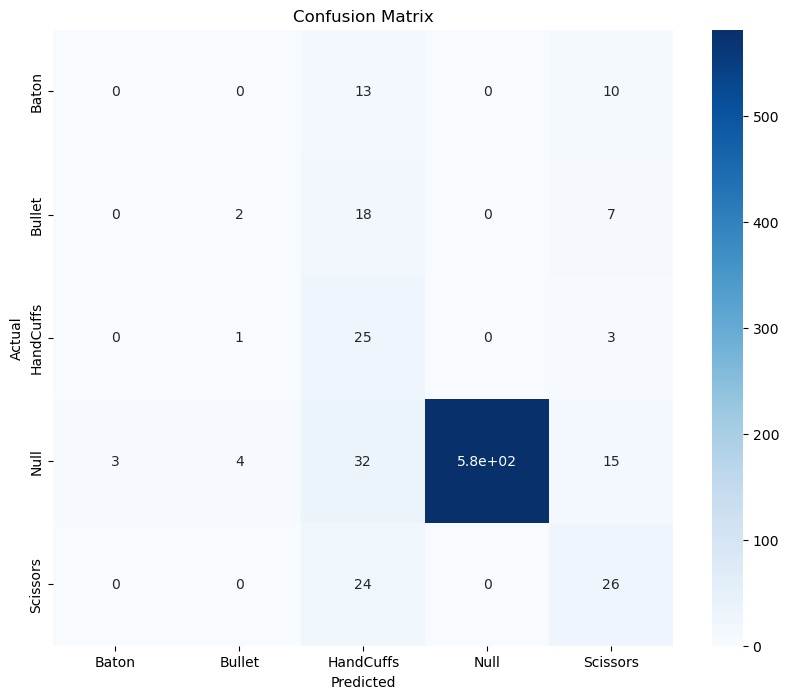

In [11]:
#This cell is for the confusion matrix 

from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        y_true += labels.tolist()
        y_pred += predicted.tolist()

# Define the correct class names in the same order as the labels
classes = ['Baton', 'Bullet', 'HandCuffs', 'Null', 'Scissors'] #needs to be in alphabetical order

cm = confusion_matrix(y_true, y_pred)
cm_df = pd.DataFrame(cm, index=classes, columns=classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_df, annot=True, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Accuracy of Baton: 0.0%
Accuracy of Bullet: 7.407407407407407%
Accuracy of HandCuffs: 86.20689655172414%
Accuracy of Null: 91.49606299212599%
Accuracy of Scissors: 52.0%


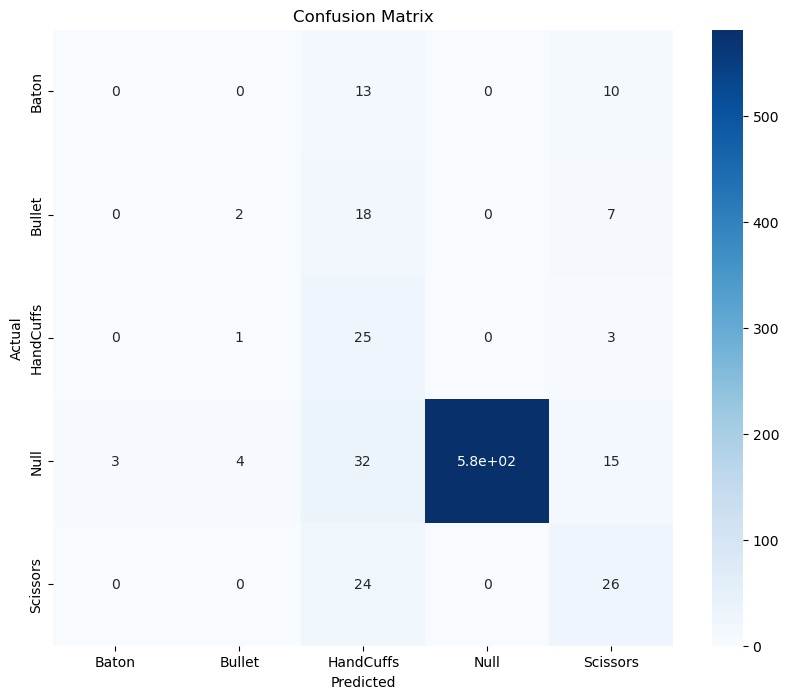

In [12]:
#This cell is for the confusion matrix 

from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        y_true += labels.tolist()
        y_pred += predicted.tolist()

# Define the correct class names in the same order as the labels
classes = ['Baton', 'Bullet', 'HandCuffs', 'Null', 'Scissors'] #needs to be in alphabetical order

# Print the accuracies for each class 

for i in range(len(classes)):
    class_total = 0
    class_correct = 0
    for j in range(len(y_true)):
        if y_true[j] == i:
            class_total += 1
            if y_pred[j] == y_true[j]:
                class_correct += 1
    print(f'Accuracy of {classes[i]}: {100 * class_correct / class_total}%')

cm = confusion_matrix(y_true, y_pred)
cm_df = pd.DataFrame(cm, index=classes, columns=classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_df, annot=True, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [13]:
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

if train_on_gpu:
    model.cuda()

n_epochs = 1
print_every = 50

for epoch in range(n_epochs):
    train_loss = 0.0
    correct = 0
    total = 0
    
    for batch_idx, (images, labels) in enumerate(train_loader):
        if train_on_gpu:
            images, labels = images.cuda(), labels.cuda()  # Move data to GPU
        
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * images.size(0)
        _, predicted = torch.max(output, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        if (batch_idx + 1) % print_every == 0:
            accuracy = 100 * correct / total
            print(f"Epoch {epoch+1}/{n_epochs}, Batch {batch_idx+1}/{len(train_loader)}, Training Loss: {train_loss / total}, Training Accuracy: {accuracy}%")
    
    train_loss = train_loss / len(train_loader.dataset)
    accuracy = 100 * correct / total
    print(f"Epoch {epoch+1}/{n_epochs}, Training Loss: {train_loss}, Training Accuracy: {accuracy}%")

CUDA is not available.  Training on CPU ...
Epoch 1/1, Batch 50/407, Training Loss: 0.5993262422084809, Training Accuracy: 75.25%
Epoch 1/1, Batch 100/407, Training Loss: 0.5328008563816548, Training Accuracy: 77.65625%
Epoch 1/1, Batch 150/407, Training Loss: 0.49596153567234674, Training Accuracy: 79.52083333333333%
Epoch 1/1, Batch 200/407, Training Loss: 0.4679708632454276, Training Accuracy: 80.9375%
Epoch 1/1, Batch 250/407, Training Loss: 0.4452418449819088, Training Accuracy: 81.825%
Epoch 1/1, Batch 300/407, Training Loss: 0.4241577063500881, Training Accuracy: 82.6875%
Epoch 1/1, Batch 350/407, Training Loss: 0.40839915375624386, Training Accuracy: 83.4375%
Epoch 1/1, Batch 400/407, Training Loss: 0.3894796500727534, Training Accuracy: 84.375%
Epoch 1/1, Training Loss: 0.38806751204976114, Training Accuracy: 84.42137639369473%


In [14]:
#Evaluate the model
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in val_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f"Validation Accuracy: {100 * correct / total}%")

Validation Accuracy: 84.40366972477064%


In [15]:
# Test over the test set

test_dataset = datasets.ImageFolder(root='/users/edatkinson/LLL/split_classes/test/', transform=transform)
#print(test_dataset)
test_loader = DataLoader(test_dataset, batch_size=10, shuffle=False)

model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f"Test Accuracy: {100 * correct / total}%")

Test Accuracy: 84.68586387434554%


Accuracy of Baton: 17.391304347826086%
Accuracy of Bullet: 11.11111111111111%
Accuracy of HandCuffs: 51.724137931034484%
Accuracy of Null: 93.38582677165354%
Accuracy of Scissors: 64.0%


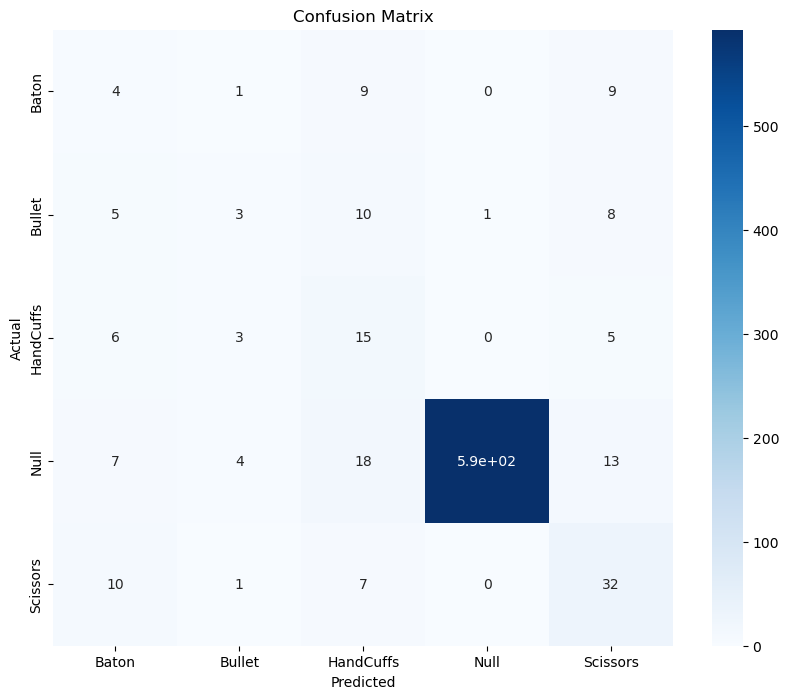

In [16]:
#This cell is for the confusion matrix 

from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        y_true += labels.tolist()
        y_pred += predicted.tolist()

# Define the correct class names in the same order as the labels
classes = ['Baton', 'Bullet', 'HandCuffs', 'Null', 'Scissors'] #needs to be in alphabetical order

# Print the accuracies for each class 

for i in range(len(classes)):
    class_total = 0
    class_correct = 0
    for j in range(len(y_true)):
        if y_true[j] == i:
            class_total += 1
            if y_pred[j] == y_true[j]:
                class_correct += 1
    print(f'Accuracy of {classes[i]}: {100 * class_correct / class_total}%')

cm = confusion_matrix(y_true, y_pred)
cm_df = pd.DataFrame(cm, index=classes, columns=classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_df, annot=True, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [17]:
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

if train_on_gpu:
    model.cuda()

n_epochs = 2
print_every = 50

for epoch in range(n_epochs):
    train_loss = 0.0
    correct = 0
    total = 0
    
    for batch_idx, (images, labels) in enumerate(train_loader):
        if train_on_gpu:
            images, labels = images.cuda(), labels.cuda()  # Move data to GPU
        
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * images.size(0)
        _, predicted = torch.max(output, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        if (batch_idx + 1) % print_every == 0:
            accuracy = 100 * correct / total
            print(f"Epoch {epoch+1}/{n_epochs}, Batch {batch_idx+1}/{len(train_loader)}, Training Loss: {train_loss / total}, Training Accuracy: {accuracy}%")
    
    train_loss = train_loss / len(train_loader.dataset)
    accuracy = 100 * correct / total
    print(f"Epoch {epoch+1}/{n_epochs}, Training Loss: {train_loss}, Training Accuracy: {accuracy}%")

CUDA is not available.  Training on CPU ...
Epoch 1/2, Batch 50/407, Training Loss: 0.25753687754273413, Training Accuracy: 89.375%
Epoch 1/2, Batch 100/407, Training Loss: 0.23618594527244569, Training Accuracy: 90.59375%
Epoch 1/2, Batch 150/407, Training Loss: 0.23376026317477228, Training Accuracy: 91.14583333333333%
Epoch 1/2, Batch 200/407, Training Loss: 0.23640918979421258, Training Accuracy: 91.125%
Epoch 1/2, Batch 250/407, Training Loss: 0.23046245236694812, Training Accuracy: 91.3625%
Epoch 1/2, Batch 300/407, Training Loss: 0.22258230202520887, Training Accuracy: 91.6875%
Epoch 1/2, Batch 350/407, Training Loss: 0.21767590320003885, Training Accuracy: 91.96428571428571%
Epoch 1/2, Batch 400/407, Training Loss: 0.2098567532002926, Training Accuracy: 92.3359375%
Epoch 1/2, Training Loss: 0.2087715250077224, Training Accuracy: 92.38754325259515%
Epoch 2/2, Batch 50/407, Training Loss: 0.14953607950359582, Training Accuracy: 95.0%
Epoch 2/2, Batch 100/407, Training Loss: 0.168

In [18]:
#Evaluate the model
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in val_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f"Validation Accuracy: {100 * correct / total}%")

Validation Accuracy: 84.27260812581913%


In [19]:
# Test over the test set

test_dataset = datasets.ImageFolder(root='/users/edatkinson/LLL/split_classes/test/', transform=transform)
#print(test_dataset)
test_loader = DataLoader(test_dataset, batch_size=10, shuffle=False)

model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f"Test Accuracy: {100 * correct / total}%")

Test Accuracy: 84.42408376963351%


Accuracy of Baton: 17.391304347826086%
Accuracy of Bullet: 29.62962962962963%
Accuracy of HandCuffs: 37.93103448275862%
Accuracy of Null: 94.01574803149606%
Accuracy of Scissors: 50.0%


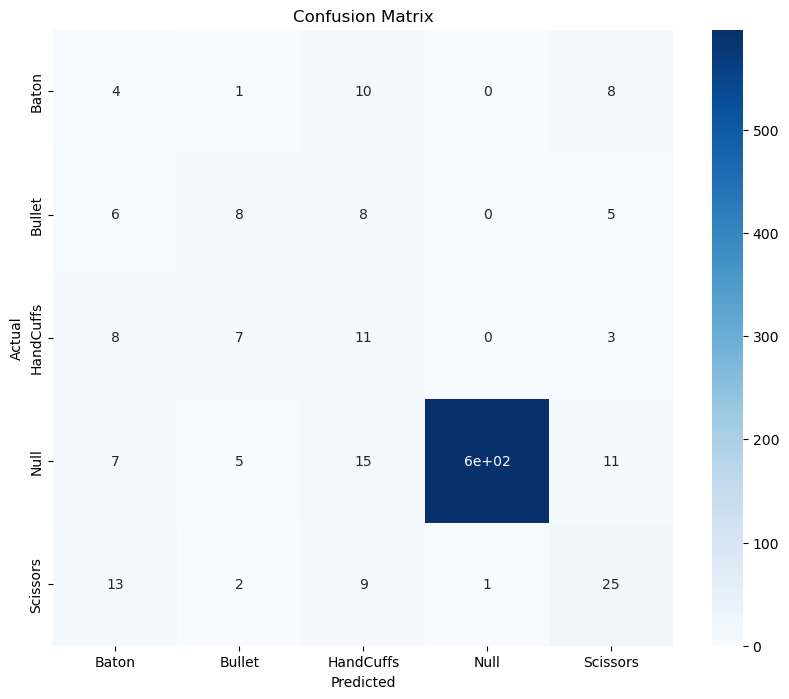

In [20]:
#This cell is for the confusion matrix 

from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        y_true += labels.tolist()
        y_pred += predicted.tolist()

# Define the correct class names in the same order as the labels
classes = ['Baton', 'Bullet', 'HandCuffs', 'Null', 'Scissors'] #needs to be in alphabetical order

# Print the accuracies for each class 

for i in range(len(classes)):
    class_total = 0
    class_correct = 0
    for j in range(len(y_true)):
        if y_true[j] == i:
            class_total += 1
            if y_pred[j] == y_true[j]:
                class_correct += 1
    print(f'Accuracy of {classes[i]}: {100 * class_correct / class_total}%')

cm = confusion_matrix(y_true, y_pred)
cm_df = pd.DataFrame(cm, index=classes, columns=classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_df, annot=True, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()